<a href="https://colab.research.google.com/github/kp1216/Cancer-Type-Detector/blob/main/Cancer_type_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
# from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization


In [ ]:
# Load metadata
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Specify the correct path as a string
metadata_path = '/content/drive/MyDrive/cancer_image_classification/HAM10000_metadata.csv'

# Load the CSV file
skin_df = pd.read_csv(metadata_path)

SIZE = 32


In [ ]:
# Encode labels as numeric values
label_encoder = LabelEncoder()
skin_df['label'] = label_encoder.fit_transform(skin_df['dx'])
print(f"Classes: {list(label_encoder.classes_)}")
print(skin_df.sample(10))

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1123  HAM_0004317  ISIC_0025504   df      histo  50.0  female   
8841  HAM_0006596  ISIC_0031081   nv      histo  35.0    male   
5884  HAM_0001271  ISIC_0030949   nv  follow_up  50.0    male   
9076  HAM_0003125  ISIC_0025477   nv      histo  55.0    male   
111   HAM_0000114  ISIC_0029674  bkl      histo  65.0    male   
1909  HAM_0005040  ISIC_0033638  mel      histo  40.0  female   
9649  HAM_0005347  ISIC_0025653   nv  consensus  55.0  female   
5743  HAM_0000424  ISIC_0031328   nv  follow_up  45.0  female   
6945  HAM_0007295  ISIC_0031380   nv      histo  60.0  female   
8737  HAM_0001330  ISIC_0026818   nv      histo  20.0  female   

         localization  label  
1123  lower extremity      3  
8841             back      5  
5884            trunk      5  
9076            chest      5  
111              face      2  
1909  upper extremity      4  
9649   

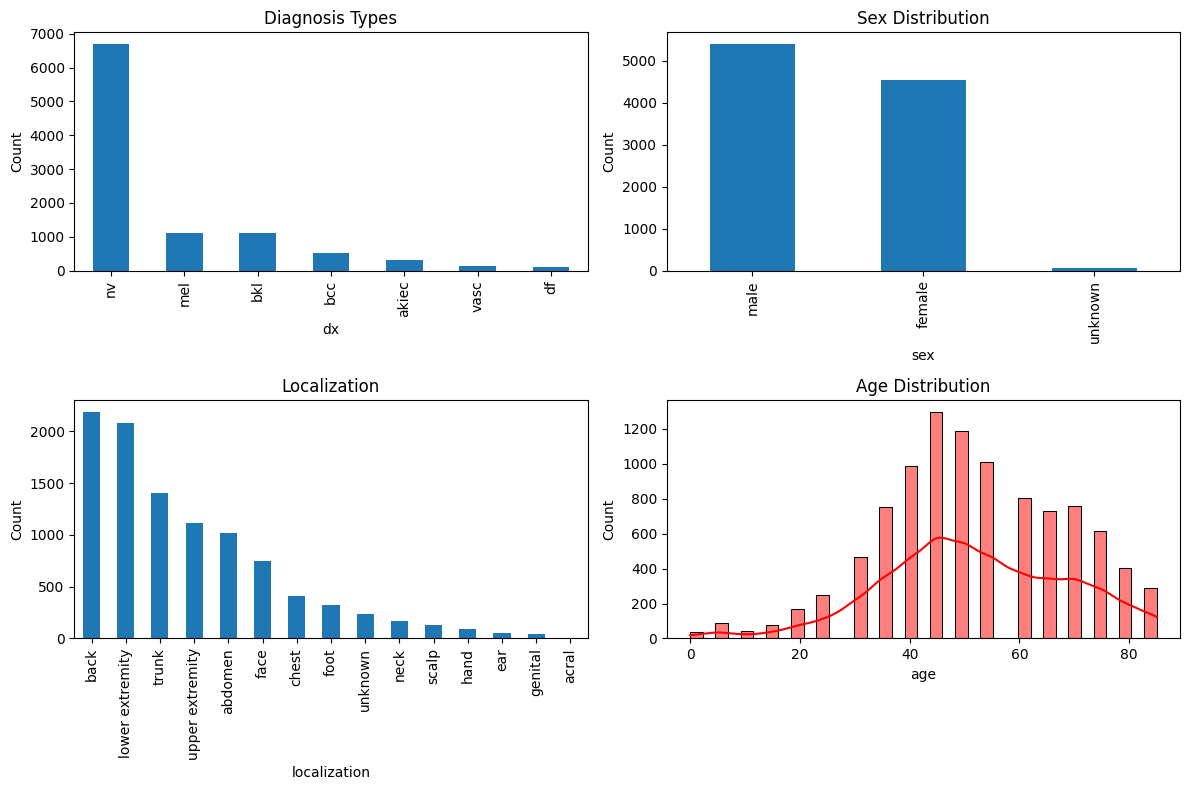

In [ ]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Distribution of diagnosis types
ax1 = axes[0, 0]
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Diagnosis Types')
# Distribution of sex
ax2 = axes[0, 1]
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count')
ax2.set_title('Sex Distribution')

# Localization of lesions
ax3 = axes[1, 0]
skin_df['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_ylabel('Count')
ax3.set_title('Localization')

# Age distribution
ax4 = axes[1, 1]
sns.histplot(skin_df['age'].dropna(), kde=True, color='red', ax=ax4)
ax4.set_title('Age Distribution')

plt.tight_layout()
plt.show()


In [ ]:
# Balance the dataset
class_counts = skin_df['label'].value_counts()
print(class_counts)

# Resample each class to balance the dataset
n_samples = 500
balanced_dfs = [resample(skin_df[skin_df['label'] == i], replace=True, n_samples=n_samples, random_state=42) for i in range(7)]
skin_df_balanced = pd.concat(balanced_dfs)

# Check the new distribution
print(skin_df_balanced['label'].value_counts())


label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [ ]:
# # Load and preprocess images
# image_paths = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/content/drive/MyDrive/cancer_image_classification/cancer_type/HAM10000/', '*', '*.jpg'))}
# skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_paths.get)
# skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))))

In [ ]:
def load_image(path):
    if path is None:
        print(f"Warning: Path is None, skipping image.")
        return None
    try:
        image = Image.open(path)
        image = image.resize((SIZE, SIZE))
        return np.asarray(image)
    except Exception as e:
        print(f"Error loading image: {path}, Error: {str(e)}")
        return None

# Create a dictionary mapping image IDs to their paths
image_paths = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join('/content/drive/MyDrive/cancer_image_classification/cancer_type/HAM10000/', '*.jpg'))
}

# Map the paths and load images
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_paths.get)

# Load and resize images, with error handling for missing paths
skin_df_balanced['image'] = skin_df_balanced['path'].map(load_image)


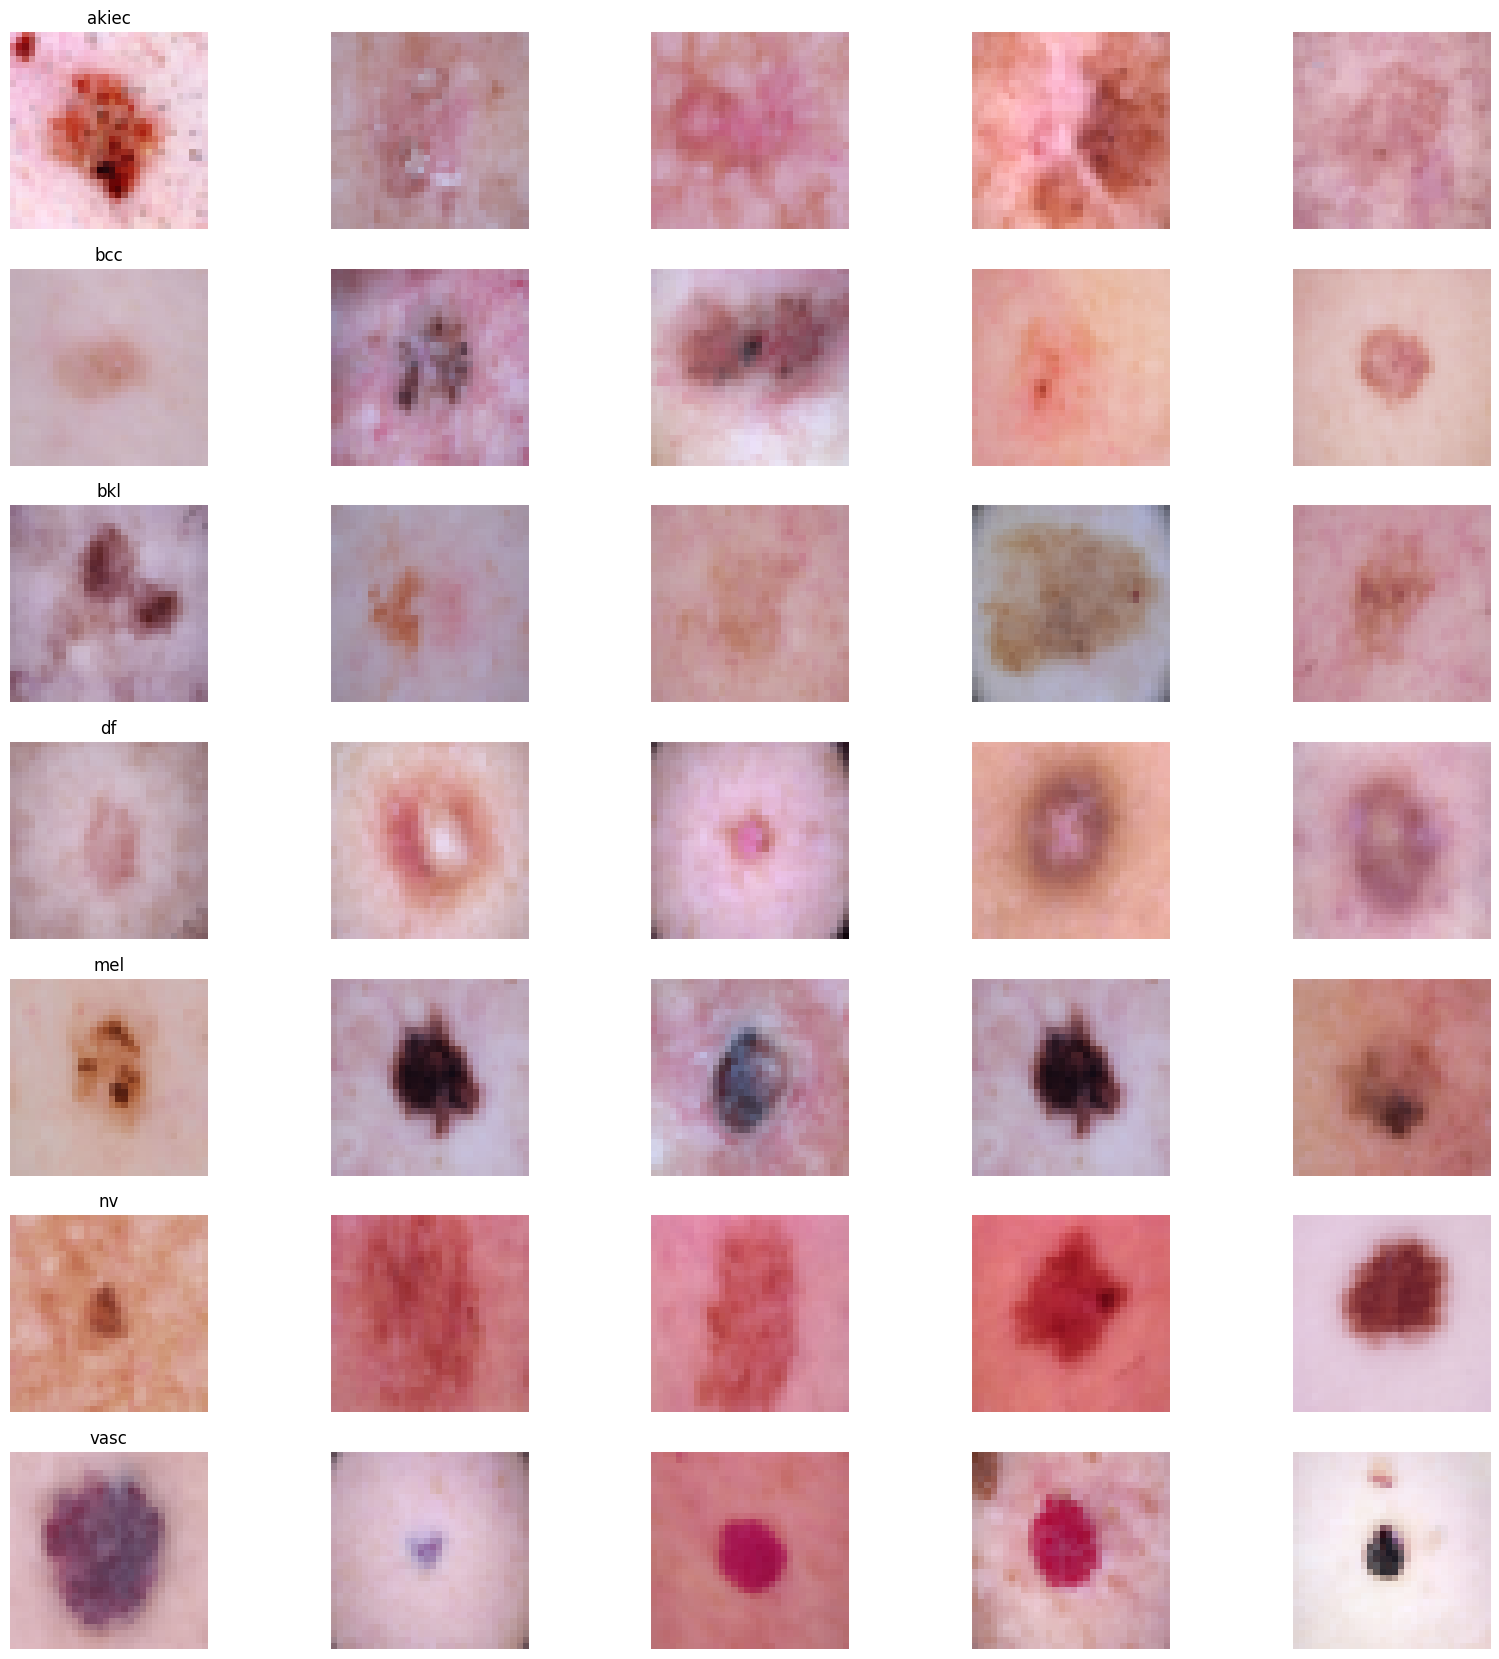

In [ ]:
# Display a sample of images
n_samples = 5
fig, axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for ax_row, (dx_type, type_rows) in zip(axs, skin_df_balanced.sort_values('dx').groupby('dx')):
    ax_row[0].set_title(dx_type)
    for ax, (_, row) in zip(ax_row, type_rows.sample(n_samples, random_state=1234).iterrows()):
        ax.imshow(row['image'])
        ax.axis('off')


In [ ]:
from tensorflow.keras.utils import to_categorical
# Ensure there are no None values in the image column
if skin_df_balanced['image'].isnull().any():
    raise ValueError("There are missing images in the dataset!")

# Convert the list of image arrays to a 4D NumPy array and normalize pixel values
X = np.array(skin_df_balanced['image'].tolist()) / 255.0

# Extract labels and convert to one-hot encoding
Y = skin_df_balanced['label'].astype(int)  # Ensure labels are integers
Y_cat = to_categorical(Y, num_classes=7)  # Adjust num_classes based on your dataset

# Check the shape of X and Y_cat to ensure correctness
print(f"Shape of X: {X.shape}")
print(f"Shape of Y_cat: {Y_cat.shape}")


Shape of X: (3500, 32, 32, 3)
Shape of Y_cat: (3500, 7)


In [ ]:
# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

model.summary()

# # Step 7: Define a simple CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])

NameError: name 'SIZE' is not defined

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
# Train the model
batch_size = 16
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7677 - loss: 1.2780
Test accuracy: 0.77


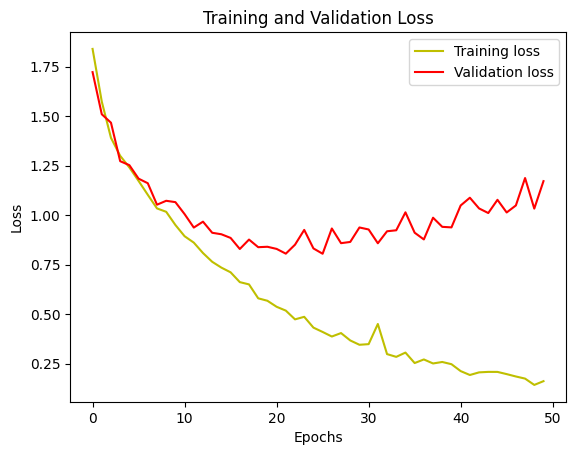

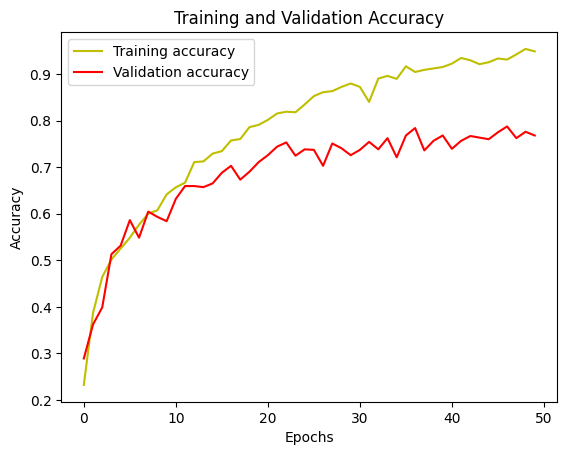

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], 'y', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], 'y', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


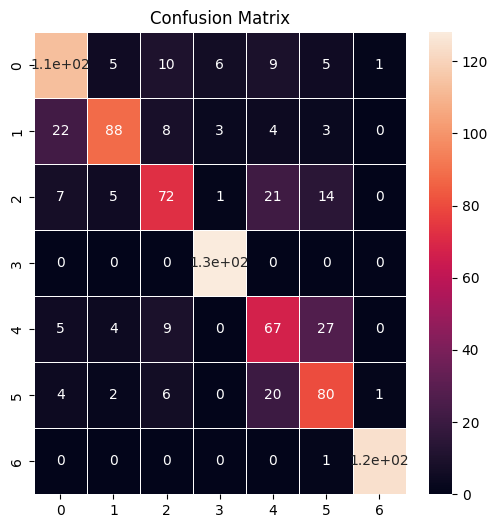

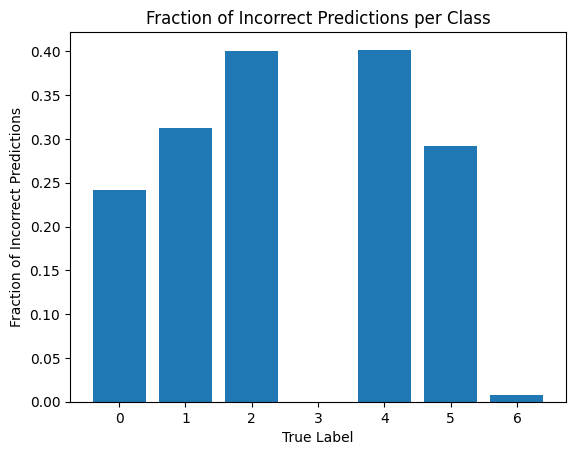

In [ ]:
# Confusion matrix and incorrect predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)
plt.title('Confusion Matrix')
plt.show()

# Plot incorrect prediction fractions
incorrect_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorrect_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Predictions')
plt.title('Fraction of Incorrect Predictions per Class')
plt.show()


Ye csv file bna kr kiya tha

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Step 1: Load the CSV file
# df = pd.read_csv('your_file.csv')

# Step 2: Extract labels and pixel data
labels = df.iloc[:, -1].values  # Assuming the last column contains labels
pixels = df.iloc[:, :-1].values  # The rest are pixel values

# Step 3: Reshape the pixel data into 28x28x3 images
images = pixels.reshape(-1, 28, 28, 3)

# Step 4: Resize the images to 32x32 pixels
resized_images = tf.image.resize(images, [32, 32])
resized_images = resized_images.numpy()  # Convert back to NumPy array

# Step 5: Normalize the pixel values
resized_images = resized_images / 255.0  # Normalize to [0, 1]

# Step 6: Convert labels to categorical (if classification)
# Assuming labels are categorical, e.g., [0, 1, 2]
num_classes = len(np.unique(labels))
labels_categorical = tf.keras.utils.to_categorical(labels, num_classes)

# Step 7: Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Step 8: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 9: Train the model
model.fit(resized_images, labels_categorical, epochs=10, batch_size=32)

# Step 10: Evaluate the model
loss, accuracy = model.evaluate(resized_images, labels_categorical)
print(f'Model accuracy: {accuracy*100:.2f}%')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.6676 - loss: 1.0649
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.6931 - loss: 0.8740
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7089 - loss: 0.7956
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.7231 - loss: 0.7638
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.7339 - loss: 0.7260
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.7363 - loss: 0.6999
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7541 - loss: 0.6714
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7586 - loss: 0.6532
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7684 - loss: 0.6169
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7698 - loss: 0.6140
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6233 - loss: 0.8922
Model accuracy: 78.78%
